# Notebook 6: Solution: Neural Network Modeling of Spindle Current

This notebook provides a complete reference solution to the neural network modeling task. We build, train, and evaluate a feedforward neural network to predict the spindle current (`ACT_CURRENT_S`) based on process variables from milling experiments.

**Main Steps:**
1. Verify data splits  
2. Scale input features  
3. Define and train a neural network  
4. Evaluate with regression metrics  
5. Visualize training and prediction results

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time
import glob

# Consistent plot style
sns.set(style="whitegrid")


files = sorted(glob.glob("Rough_Train_New*.csv.gz"))
dfs = [pd.read_csv(f, compression="gzip") for f in files]
df_Train = pd.concat(dfs, ignore_index=True)
df_Test = pd.read_csv("Rough_Test_New.csv.gz", compression="gzip")
df_Test_2 = pd.read_csv("Rough_Test_D6D6D8.csv.gz", compression="gzip")
df_Val = pd.read_csv("Rough_Val_New.csv.gz", compression="gzip")


## Step 1: Verify that training and test data are independent


In [2]:
# Check if any samples overlap between train and test sets
overlap = pd.merge(df_Train, df_Test, how='inner')
if not overlap.empty:
    print("⚠️ Overlap detected between training and test data!")
    print(overlap)
else:
    print("✅ No overlap detected between training and test data.")

✅ No overlap detected between training and test data.


## Step 2: Define target and features


In [3]:
target_variables = ['ACT_CURRENT_S']

features = [
    'ACTIVE_TOOL_LENGTH', 'SPINDLE_SPEED', 'Fz_N', 'Fy_N', 'Fx_N',
    'MultiDexel:GridX-EngagementHeight', 'MultiDexel:GridY-EngagementHeight', 
    'MultiDexel:GridZ-EngagementHeight', 'Tool_Diameter', 'Feed_Rate', 
    'Feed_per_Tooth', 'Cutting_Speed', 'ae', 'Qw', 'F_xyz'
]

## Step 3: Data scaling

Neural networks perform best when input data are standardized. We use `StandardScaler` to scale all features to zero mean and unit variance.

In [4]:
scaler = StandardScaler()

X_train = scaler.fit_transform(df_Train[features])
y_train = df_Train['ACT_CURRENT_S'].values

X_val = scaler.transform(df_Val[features])
y_val = df_Val['ACT_CURRENT_S'].values

X_test = scaler.transform(df_Test[features])
y_test = df_Test['ACT_CURRENT_S'].values


## Step 4: Build and train the neural network

We optimized the hyperparameters of the **dense neural network** model using **Optuna**, an advanced framework for automated hyperparameter search. The objective of the tuning process is to find the combination of neural network parameters that minimizes the **validation Mean Squared Error (MSE)** when predicting the spindle current (`ACT_CURRENT_S`).

**Optuna** is a powerful optimization library designed for automatic hyperparameter tuning. It performs an intelligent search using a **Tree-structured Parzen Estimator (TPE)** approach to efficiently explore promising hyperparameter regions.
Each **trial** in the study represents one complete training and evaluation of the neural network with a unique set of hyperparameters.

### Hyperparameters Tuned

During optimization, the following hyperparameters are varied:

| Hyperparameter | Description | Range / Values |
|----------------|-------------|----------------|
| `num_layers` | Number of hidden dense layers | 1 – 3 |
| `units_layer_i` | Number of neurons in each layer | 32 – 256 (step = 32) |
| `dropout` | Dropout rate for regularization | 0.03 – 0.05 |
| `learning_rate` | Learning rate for the Adam optimizer | 0.0004 – 0.0006 |
| `batch_size` | Training batch size | [16, 32, 64, 128] |

---

### Search Strategy

- Optuna samples hyperparameters for each trial using probabilistic models (TPE sampler).  
- The **Median Pruner** stops unpromising trials early to save computation time.  
- After each trial, the model is evaluated on the **validation set**, and the resulting **MSE** is returned to Optuna.  
- Validation metrics such as **MAE** and **R²** are stored as additional attributes for later analysis.

---

### Evaluation and Selection

- The **best-performing trial** is identified as the one with the lowest validation MSE.  
- The corresponding hyperparameters are saved for final model training and testing.  
- Metrics on both the validation and test sets are printed to assess model generalization.

---

### Key Advantages of Optuna

- **Automated search** across complex parameter spaces  
- **Efficient pruning** of poor-performing models  
- **Reproducibility** through study storage (SQLite database)  
- **Transparent tracking** of metrics and best configurations

---

This tuning approach ensures that the neural network achieves a **balanced combination of performance and generalization**,  
providing a robust baseline for further modeling experiments in milling process analysis.

In [5]:
# Best hyperparameters from tuning with Optuna
best_dense_params = {
    'num_layers': 2,  # Number of dense layers
    'units_layer_1': 256,  # Number of units in the first dense layer
    'units_layer_2': 256,  # Number of units in the second dense layer
    'dropout': 0.04,  # Dropout rate for regularization
    'learning_rate': 0.0004132555126120325,  # Optimizer learning rate
    'batch_size': 64  # Batch size for training
}

# Training loop for the dense-only model
for target in target_variables:
    print(f"\nTraining Dense-only model for {target}...\n")
    start_time = time.time()  # Record start time for training

    # Data scaling (preprocessing)
    scaler = StandardScaler()  # Initialize a standard scaler

    # Scale the training, validation, and test features
    X_train_dense = scaler.fit_transform(df_Train[features])  # Fit and transform training features
    y_train_cnn = df_Train[target].values  # Extract target variable for training

    X_test_dense = scaler.transform(df_Test[features])  # Transform test features
    y_test_cnn = df_Test[target].values  # Extract target variable for testing

    X_val_dense = scaler.transform(df_Val[features])  # Transform validation features
    y_val_cnn = df_Val[target].values  # Extract target variable for validation

    # Dynamically create the dense model based on best hyperparameters
    dense_model = Sequential()  # Initialize the Sequential model

    # Add input layer (first dense layer)
    dense_model.add(
        Dense(
            best_dense_params['units_layer_1'],
            activation='relu',
            input_shape=(X_train_dense.shape[1],)
        )
    )
    dense_model.add(Dropout(best_dense_params['dropout']))  # Add dropout after the first layer

    # Add additional hidden layers dynamically based on 'num_layers'
    for layer_num in range(2, best_dense_params['num_layers'] + 1):
        dense_model.add(Dense(best_dense_params[f'units_layer_{layer_num}'], activation='relu'))
        dense_model.add(Dropout(best_dense_params['dropout']))  # Add dropout after each hidden layer

    # Add output layer (single neuron for regression output)
    dense_model.add(Dense(1))

    # Compile the model
    dense_model.compile(
        optimizer=Adam(learning_rate=best_dense_params['learning_rate']),  # Use Adam optimizer with the best learning rate
        loss='mse',  # Mean Squared Error as the loss function for regression
        metrics=['mae']  # Track Mean Absolute Error as an additional evaluation metric
    )

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss to determine early stopping
        patience=35,  # Number of epochs with no improvement before stopping
        restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
        verbose=1  # Print messages when early stopping is triggered
    )

    # Train the model
    history = dense_model.fit(
        X_train_dense, y_train_cnn,  # Training features and target
        validation_data=(X_val_dense, y_val_cnn),  # Validation features and target
        epochs=50,  # Maximum number of epochs for training
        initial_epoch=0,  # Start training from the first epoch
        batch_size=best_dense_params['batch_size'],  # Batch size for training
        callbacks=[early_stopping],  # Use the EarlyStopping callback
        verbose=1  # Print training progress and metrics at each epoch
    )


Training Dense-only model for ACT_CURRENT_S...

Epoch 1/50


C:\Users\mezghani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3374/3374 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.1117 - mae: 0.1834 - val_loss: 0.0210 - val_mae: 0.1002
Epoch 2/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0242 - mae: 0.1011 - val_loss: 0.0168 - val_mae: 0.0793
Epoch 3/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0202 - mae: 0.0921 - val_loss: 0.0138 - val_mae: 0.0742
Epoch 4/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0177 - mae: 0.0855 - val_loss: 0.0121 - val_mae: 0.0700
Epoch 5/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0163 - mae: 0.0821 - val_loss: 0.0116 - val_mae: 0.0647
Epoch 6/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0147 - mae: 0.0781 - val_loss: 0.0105 - val_mae: 0.0638
Epoch 7/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0137 - mae: 0.0752 - val_loss: 0.0102 - val_mae: 0.0622
Epoch 8/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0130 - mae: 0.0729 - val_loss: 0.0106 - val_mae: 0.0613
Epoch 9/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 1

## Step 5: Evaluate model performance


In [6]:
# Generate predictions on the test set
y_pred = dense_model.predict(X_test_dense)  # Predict target values for the test set

# Calculate performance metrics
mse = mean_squared_error(y_test_cnn, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y_test_cnn, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test_cnn, y_pred)  # R² score

# Print the calculated metrics
print(f"Model Evaluation for {target}:")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")


1450/1450 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Model Evaluation for ACT_CURRENT_S:
Test R²: 0.9903
Test MAE: 0.0467
Test MSE: 0.0063


## Step 6: Visualize results


Model Evaluation for ACT_CURRENT_S:
Test R²: 0.9903
Test MAE: 0.0467
Test MSE: 0.0063


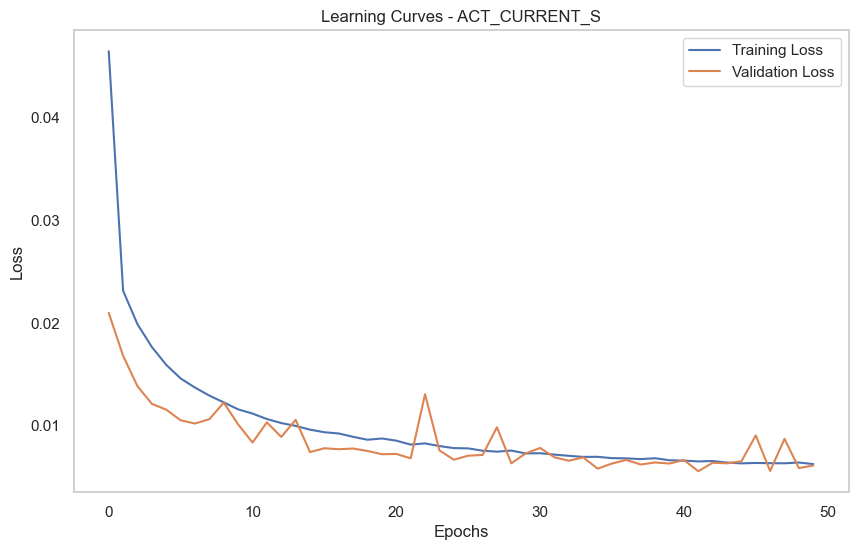

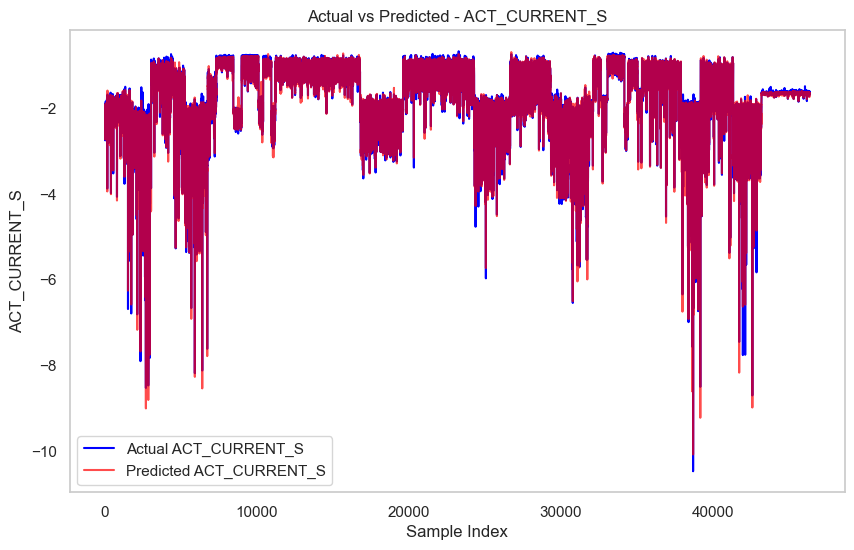

In [7]:
# Print the calculated metrics
print(f"Model Evaluation for {target}:")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")

# Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title(f'Learning Curves - {target}')  # Add title
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.legend()  # Add legend
plt.grid()  # Add grid for better readability

# Predictions vs. Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test_cnn, label=f'Actual {target}', color='blue')  # Plot actual values
plt.plot(y_pred, label=f'Predicted {target}', color='red', alpha=0.7)  # Plot predicted values
plt.title(f'Actual vs Predicted - {target}')  # Add title
plt.xlabel('Sample Index')  # Label for x-axis
plt.ylabel(target)  # Label for y-axis
plt.legend()  # Add legend
plt.grid()  # Add grid for better readability


plt.show()

## Result Analysis

The training and validation loss curves show a **smooth and stable convergence**. Both losses decrease rapidly during the first few epochs and then flatten around epoch 25–30, indicating that the model has effectively learned the underlying relationships without overfitting.

- The **validation loss** remains close to the **training loss**, which confirms that the model generalizes well to unseen data.

### Quantitative Evaluation

| Metric | Description | Value |
|---------|-------------|-------|
| **R² (Test)** | Coefficient of determination – how well predictions match the actual values | **0.9903** |
| **MAE (Test)** | Mean Absolute Error – average deviation of predictions | **0.0467** |
| **MSE (Test)** | Mean Squared Error – squared average of prediction errors | **0.0063** |

### Interpretation

- An **R² of 0.99** indicates that the model explains almost **99% of the variance** in spindle current values.  
- The **low MAE and MSE** confirm that prediction errors are small and consistent.  
- The close alignment between training and validation losses suggests **minimal overfitting**.  
- Overall, the neural network demonstrates **excellent performance** in modeling the spindle current (`ACT_CURRENT_S`) based on the selected process parameters.
